> Welcome to the notebook! This is my submission notebook file for the [Fellowship.ai](https://www.fellowship.ai/) Cohort 34, NLP challenge.

First, let's analyze dataset. Link to the dataset: [IMDB Dataset of 50K Movie Reviews](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/discussion?sort=hotness)

In [1]:
# !pip install fastai

In [2]:
#@ Since I'm using Kaggle's notebook itself, I don't need to import kaggle and stuffs.
import pandas as pd 

ds = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

## Preprocessing.... 

---

In [3]:
ds.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


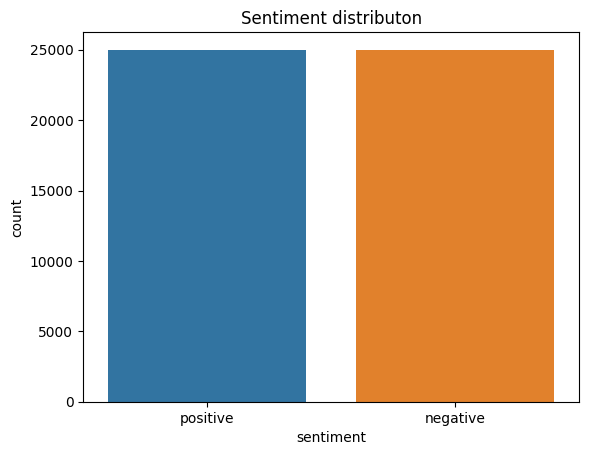

In [4]:
##@ Looking at dataset distribution

import seaborn as sns 
import matplotlib.pyplot as plt 

sns.countplot(data= ds, x='sentiment')
plt.title('Sentiment distributon')
plt.show()

So, the dataset contains **equal number of positive and negative sentiments**

In [5]:
ds.columns = ds.columns.str.strip()

In [6]:
##@ Converting sentiments to binary values: its easier to process that way 
ds['sentiment'] = ds['sentiment'].map({'positive': 1, 'negative': 0})

In [7]:
import re

##@ Also I see some html tags in dataset, so cleaning them
def clean_text(text):
    text = text.lower() 
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)  ##added later on to remove all characters that were not letters or whitespace
    return text.strip()

ds['review']= ds['review'].apply(clean_text)

ds['review'].head()

0    one of the other reviewers has mentioned that ...
1    a wonderful little production the filming tech...
2    i thought this was a wonderful way to spend ti...
3    basically theres a family where a little boy j...
4    petter matteis love in the time of money is a ...
Name: review, dtype: object

In [8]:
 ##@ Also checking if there are any NULL values 
print(ds.isnull().sum())

review       0
sentiment    0
dtype: int64


In [9]:
print(isinstance(ds, pd.DataFrame))

True


In [10]:
ds.columns = ds.columns.str.strip()

ds.columns

Index(['review', 'sentiment'], dtype='object')

In [11]:
type(ds)

pandas.core.frame.DataFrame

In [12]:
ds.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production the filming tech...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically theres a family where a little boy j...,0
4,petter matteis love in the time of money is a ...,1


That's good.. No Null values 😲

---

## Implementation phase ... 

---

Will implement the sentiment analysis using fast.ai library.

Okay, so I tried passing `'review'` on TextBlock, and unfortunately it threw an error. So renaming in standard format to avoid the error. 

In [13]:
ds = ds.rename(columns= {'review': 'text', 'sentiment': 'label'})

print(ds.head())

                                                text  label
0  one of the other reviewers has mentioned that ...      1
1  a wonderful little production the filming tech...      1
2  i thought this was a wonderful way to spend ti...      1
3  basically theres a family where a little boy j...      0
4  petter matteis love in the time of money is a ...      1


Now, time to get the transformers... 

In [ ]:
from fastai.text.all import *
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch.utils.data import Dataset
from datasets import Dataset as HFDataset

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenize the inputs
tokenized_inputs = tokenizer(
    ds['text'].tolist(),
    truncation=True,
    padding=True,
    max_length=512
)

# Create a Hugging Face dataset
hf_dataset = HFDataset.from_dict({
    'input_ids': tokenized_inputs['input_ids'],
    'attention_mask': tokenized_inputs['attention_mask'],
    'labels': ds['label'].tolist()
})

# Split the dataset into train and test sets
train_test_split = hf_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, dataset, device):
        self.dataset = dataset
        self.device = device

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        input_ids = torch.tensor(self.dataset['input_ids'][idx]).to(self.device)
        attention_mask = torch.tensor(self.dataset['attention_mask'][idx]).to(self.device)
        labels = torch.tensor(self.dataset['labels'][idx]).to(self.device)
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels
        }
        
# Create data loaders
train_dataloader = torch.utils.data.DataLoader(CustomDataset(train_dataset, device), batch_size=16, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(CustomDataset(test_dataset, device), batch_size=16)

# Initialize the model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.to(device)

# Create a DataLoaders object
dls = DataLoaders(train_dataloader, val_dataloader)

# Define the loss function
loss_func = CrossEntropyLossFlat()

# Create the Learner
learn = Learner(
    dls=dls,
    model=model,
    loss_func=loss_func,
    metrics=accuracy
)

# Train the model
learn.fit_one_cycle(4, lr_max=1e-5)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch,train_loss,valid_loss,accuracy,time
